# Zombies Spread Dynamics
Simulation of the spread of a zombie epidemic in Europe, based on the modeling of the territory with graph theory, in order to take control measures with military troops and nuclear bombs to save the largest possible population. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import os, tqdm, copy
import numpy as np
import datetime as dt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
plt.style.use('default')

from libraries.dynamics import spread_zombie_dynamics as szd
from libraries.dynamics import graph_by_default

## Network reading
After executing the notebook [graph construction](https://github.com/TEAM-IMT/zombies-spread-dynamics/blob/main/Codes/Challenge_2_graphconstruction.ipynb), the file **All_nodes_graph.gexf** will be generated. For convenience, we provide this file in zip format. The file is then unzipped.

In [2]:
graph_zip = './graph/without_see_nodes_graph_ini_2.zip'
graph_path = graph_zip.replace('.zip','.gexf')
if not os.path.isfile(graph_path):
    if not os.path.isdir('graph'): os.mkdir('graph')
    !unzip $graph_zip -d "./graph"
print('[INFO] File unzip successfully.')

[INFO] File unzip successfully.


## Epidemic spread
As a first view, let's load the network and see the initial state of the two populations

In [3]:
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [4]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
graph_pos = {G.nodes[n]['node_id']:(eval(n)[1],-eval(n)[0]) for n in G.nodes()}

[INFO] Graph was modified ...


In [5]:
dynamic.reset()
dynamic.graph_pos = graph_pos # Use variable to set an unique perspective

<IPython.core.display.Javascript object>


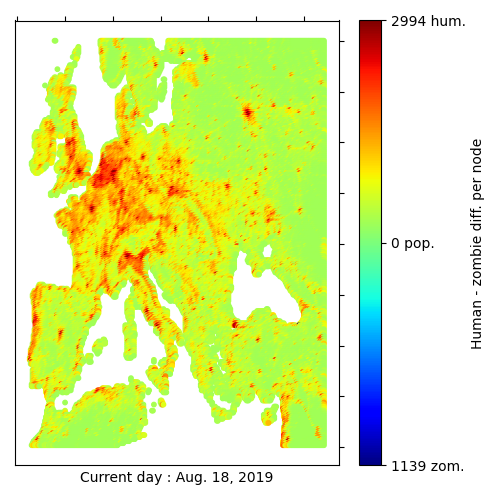

------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		18-08-2019
Total human population: 	29424646 (100.00\% of all population)
Total zombie population: 	1139 (0.00\% of all population)
Total human killed: 		0 (0.00\% of all population)
------------------------------


In [6]:
fig, ax = plt.subplots(figsize = (5,5))
dynamic.plot_graph(ax = ax)
print(dynamic)
# Cell aux
# for neig in dynamic.graph.neighbors('U45375'):
#     print("[INFO] humanpop in",neig,":",dynamic.graph.nodes[neig]['human_pop'],
#           "\tzombiepop :",dynamic.graph.nodes[neig]['zombie_pop'],
#          "\twith elev {}".format(('U45375',neig)),":",dynamic.graph.edges[('U45375',neig)]['elev_factor'])

In [7]:
print('[INFO] First zombie population in Rize', dynamic.graph.nodes['U45375']['zombie_pop'])
print('[INFO] First human population in Brest', dynamic.graph.nodes['U28058']['human_pop'])

[INFO] First zombie population in Rize 1139
[INFO] First human population in Brest 1532


Now, let's see how it evolves over time, over the course of two months.

  0%|          | 0/367 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


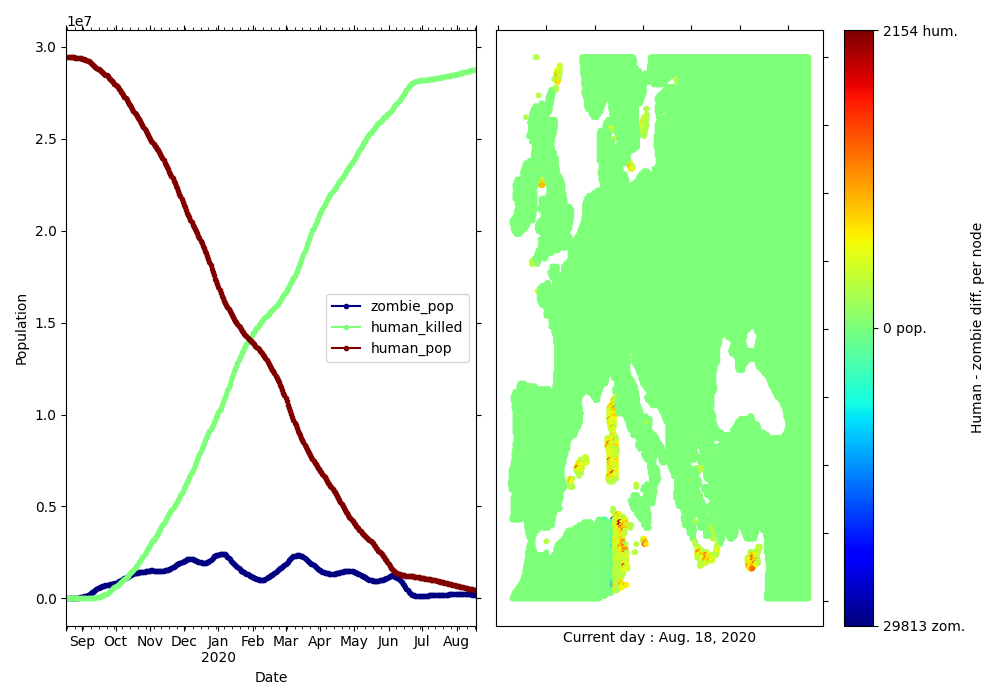

 72%|███████▏  | 265/367 [4:38:12<1:12:09, 42.45s/it] 

[INFO] Zombies arrive to Brest in May. 09, 2020


100%|██████████| 367/367 [5:42:58<00:00, 56.07s/it]  


In [8]:
# User values
DATE_END = dt.datetime.strptime('18-08-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ = '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_wa.mp4"
metadata = dict(title = 'Dynamic spread zombie without action', artist = 'TEAM-IMT', comment = 'Dynamic evolution without any action')

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        if dynamic.current_date < DATE_END: dynamic.step()
        elif dynamic.current_date == DATE_END: endtrigger = False

After two months, approximately one fifth of the land was conquered by the two zombies, turning 4.67% of the population into zombies, and eradicating 5.57% of the people on the European continent.

In [24]:
dynamic.load_checkpoint('checkpoints/szd_17-10-2019.dyn')
print(dynamic)

------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		17-10-2019
Total human population: 	26507481 (90.08\% of all population)
Total zombie population: 	1356372 (4.61\% of all population)
Total human killed: 		1561932 (5.31\% of all population)
------------------------------


On the other hand, we see how the epidemic arrives in Brest on May 9, 2020 (approximately 9 months after the start of the epidemic).

In [25]:
dynamic.load_checkpoint('checkpoints/without_action/szd_09-05-2020.dyn')
print('[INFO] Population in Brest', dynamic.graph.nodes['U28058']['human_pop'])
print(dynamic)

[INFO] Population in Brest 0
------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		09-05-2020
Total human population: 	3513060 (11.94\% of all population)
Total zombie population: 	1210795 (4.11\% of all population)
Total human killed: 		24701930 (83.95\% of all population)
------------------------------


<IPython.core.display.Javascript object>


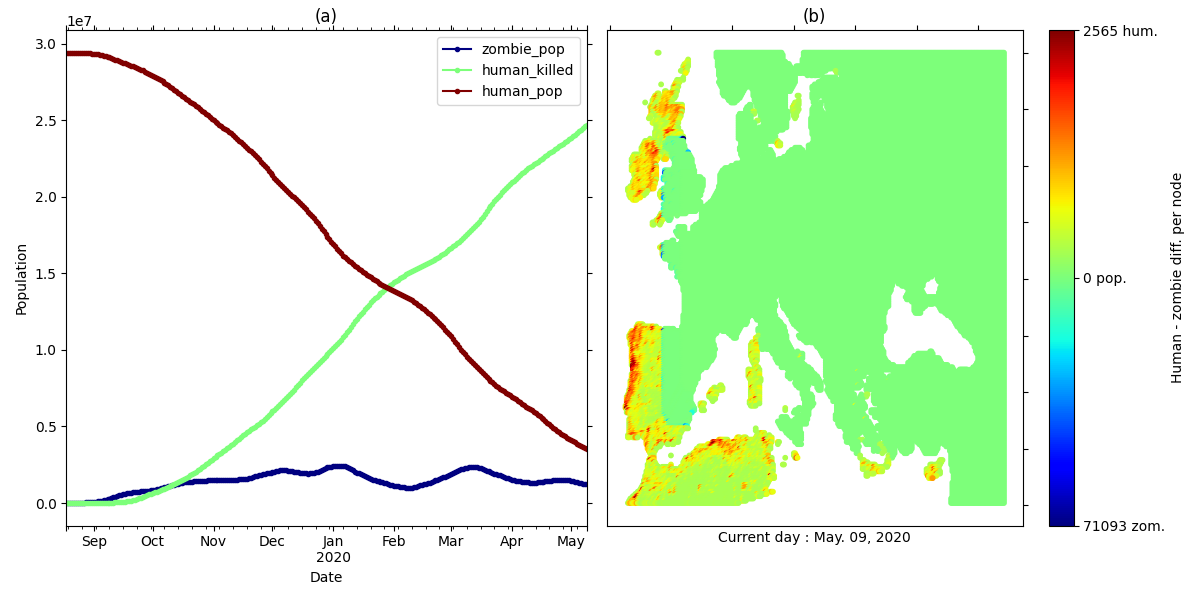

In [26]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
dynamic.plot_all(axs = axs)
axs[0].set_title('(a)'); axs[1].set_title('(b)')
# fig.tight_layout()
fig.savefig('images/brest_arrive_wa.png', dpi = 300,)

## After 2 months: military trops
In order to reduce the impact of the zombies, two months into the simulation, we will execute the action of 20 military troops. For this purpose, we will load the initial state of the network one day before the two months (August 17, 2019).

In [10]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [11]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.load_checkpoint('checkpoints/szd_17-10-2019.dyn')

[INFO] Graph was modified ...


Now, we define the date of deployment of the troops and the cells they will affect. These cells were previously designed in the [cell notebook](https://github.com/TEAM-IMT/zombies-spread-dynamics/blob/main/cells.ipynb).

In [13]:
# Definition of military trops position
dynamic.MILITARY_TROPS = {dt.datetime.strptime('18-10-2019', '%d-%m-%Y'): # Start day with military trops
                  ['U59527','U59531','U59532','U26026','U55959','U26030','U47909','U26058',
                   'U26057','U26029','U59569','U59553','U26053','U26035','U32133','U56302',
                   'U59533','U26059','U26027','U59554']} # Cells with military deployment 

Finally, we run the simulation cycle

  0%|          | 0/367 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


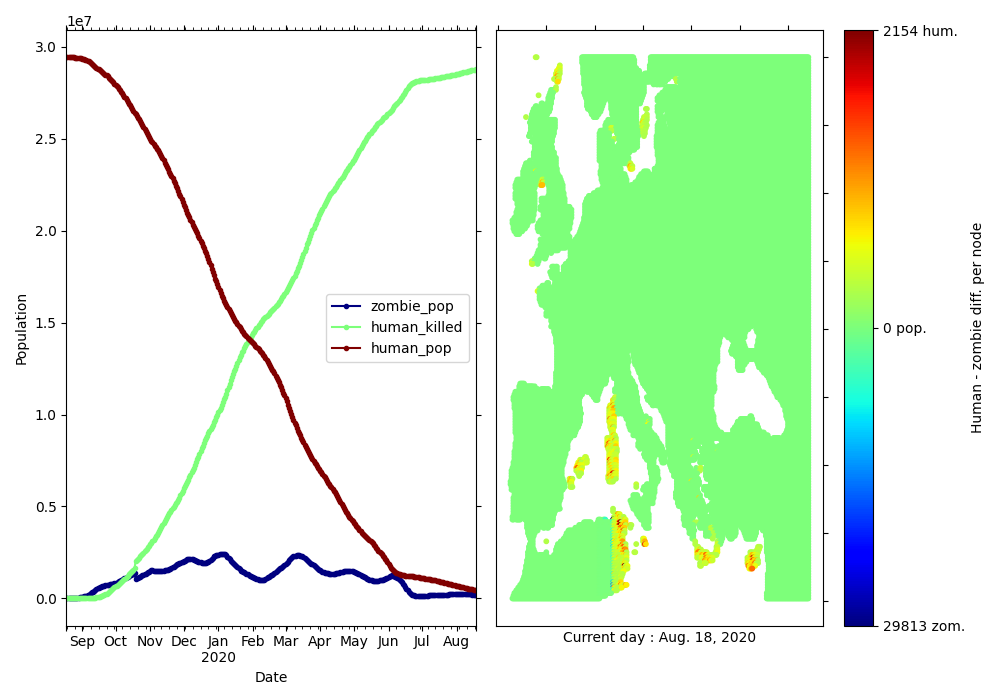

  0%|          | 1/367 [00:44<4:30:43, 44.38s/it]

[INFO] Military trops in 2019-10-18 00:00:00


 56%|█████▌    | 205/367 [2:17:51<1:25:49, 31.79s/it]

[INFO] Zombies arrive to Brest in May. 09, 2020


100%|██████████| 367/367 [3:15:48<00:00, 32.01s/it]  


In [14]:
# User values
DATE_END = dt.datetime.strptime('18-08-2020', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ = '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_military.mp4"
metadata = dict(title = 'Dynamic with military action', artist = 'TEAM-IMT', comment = 'Dynamic evolution with military action')

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        if dynamic.current_date < DATE_END: dynamic.step()
        elif dynamic.current_date == DATE_END: endtrigger = False

At the end of the simulation, we see how 20 military troops are not enough to impact the propagation to a greater extent compared to the simulation without any action. It will be necessary to resort to drastic measures

In [15]:
print(dynamic)

------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		18-08-2020
Total human population: 	459143 (1.56\% of all population)
Total zombie population: 	195808 (0.67\% of all population)
Total human killed: 		28770834 (97.77\% of all population)
------------------------------


## After 4 months: nuclear bombs
Given the large increase in spread after four months, the deployment of nuclear bombs will be necessary. For this purpose, the state after four months will be loaded.

In [11]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)

In [12]:
dynamic = szd(graph = G, INTIAL_DATE = ini_date)
dynamic.load_checkpoint('checkpoints/szd_17-12-2019.dyn')

[INFO] Graph was modified ...


The bomb strategy will be to explode the nodes with the highest zombie population, according to the CDF of all zombie nodes. This will be done every few days until the population is completely eradicated. The following function defines the cells that will be bombed.

In [13]:
# Definition of function to caculate bombs
def cells_bombs(G, date, beta = 0.9):
    zombiesquantity = nx.classes.function.get_node_attributes(G, 'zombie_pop')
    numberzombies = {i:v for i,v in zombiesquantity.items() if v > 0}
    humanquantity = nx.classes.function.get_node_attributes(G, 'human_pop')
    humanquantity = {i:v for i,v in humanquantity.items() if v > 0}
    meanhumans = np.mean(list(humanquantity.values()))
    hist, bins = np.histogram(list(numberzombies.values()), bins =100)
    hist = np.cumsum(hist)
    zombies = np.argmin(np.abs(hist - ((hist[-1] - hist[0]) * beta+ hist[0])))
    if len(numberzombies) == 0 or max(list(numberzombies.values())) < meanhumans: 
        return {} # No bombs beacuse humans will kill zombies
    else:
        return {date: [i for i,v in numberzombies.items() if v >= bins[zombies]]}

We start the simulation run cell

  0%|          | 0/732 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


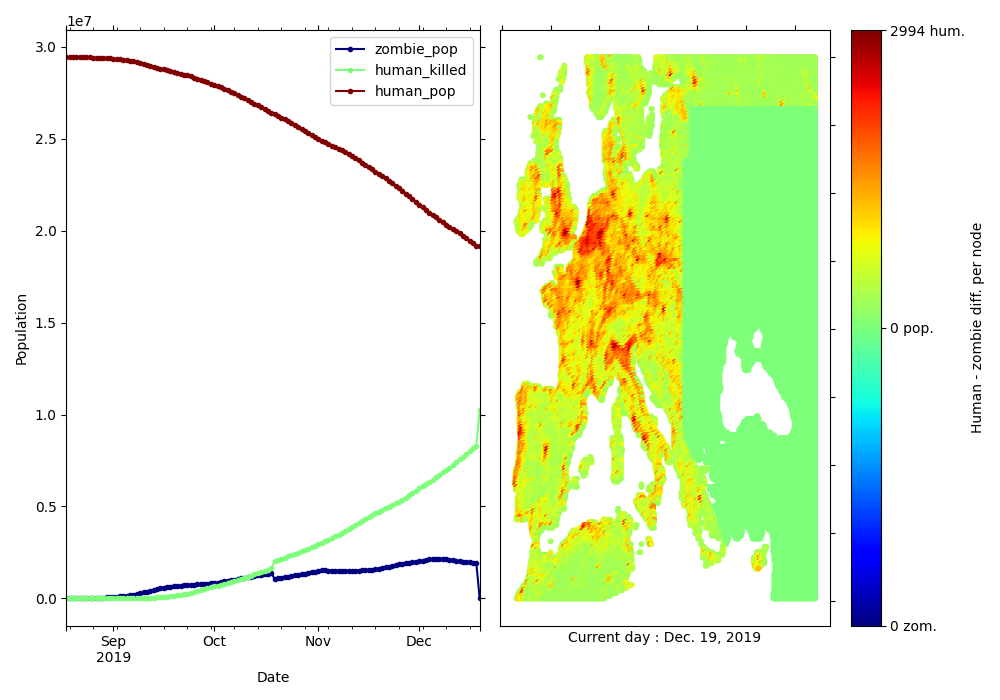

  0%|          | 1/732 [00:44<9:04:26, 44.69s/it]

[INFO] Nuclear bombs in 2019-12-18 00:00:00


100%|██████████| 732/732 [04:43<00:00,  2.58it/s]  


In [14]:
# User values
DATE_END = dt.datetime.strptime('18-08-2021', '%d-%m-%Y') # Dynamic until this date
SPECIAL_CK_DATES = pd.to_datetime(['17-10-2019', '17-12-2019', '17-02-2019', DATE_END]) # 2-4-6 months
CK_FREQ, BOMBS_FREQ = '15D', '15D' # Checkpoints each 15days
video_name = "demo/anima_zombie_bombs_beta03-1D.mp4"
metadata = dict(title = 'Dynamic with nuclear bombs', artist = 'TEAM-IMT', comment = 'Dynamic evolution with nuclear bombs action')
bombs_dates = pd.date_range(start = '18-12-2019', end = DATE_END, freq = BOMBS_FREQ) # List of bombs days
beta = 0.03

# Define range dates and checkpoints
total_days = (DATE_END - dynamic.INTIAL_DATE).days + 1
date_cp = pd.date_range(start = dynamic.INTIAL_DATE, end = DATE_END, freq = CK_FREQ)
date_cp = date_cp.append(SPECIAL_CK_DATES)

# Create animation loop
fig, axs = plt.subplots(1,2, figsize = (10,7))
writer = FFMpegWriter(fps = 15, metadata = metadata)
trigger, endtrigger = True, True
with writer.saving(fig, video_name, 300):
    for epoch in tqdm.tqdm(range(total_days)):
        if dynamic.current_date <= DATE_END and endtrigger:
            dynamic.plot_all(axs = axs)
            writer.grab_frame() # Run one step in dynamic procedure
        if dynamic.current_date in date_cp:
            dynamic.save_checkpoint()
        if dynamic.graph.nodes['U28058']['zombie_pop'] > 0 and trigger:
            trigger = False
            print("[INFO] Zombies arrive to Brest in", dynamic.current_date.strftime("%b. %d, %Y"))
            dynamic.save_checkpoint()
        # Update step just until DATE_END
        bomb_date = dynamic.current_date # + dt.timedelta(days = 1)
        if bomb_date in bombs_dates:
            if dynamic.NUCLEAR_BOMBS is None: dynamic.NUCLEAR_BOMBS = cells_bombs(dynamic.graph, bomb_date, beta)
            else: dynamic.NUCLEAR_BOMBS.update(cells_bombs(dynamic.graph, bomb_date, beta))
        if dynamic.total_zombies == 0 or dynamic.current_date == DATE_END: # Final conditions
            endtrigger = False
            dynamic.save_checkpoint()
        if dynamic.current_date < DATE_END and endtrigger: 
            dynamic.step()

In [15]:
print("[INFO] Total bombs used:",sum([len(x) for x in dynamic.NUCLEAR_BOMBS.values()]))
print(dynamic)

[INFO] Total bombs used: 3683
------------------------------
INITIAL GRAPH DESCRIPTION:
Name: Zombie epidemic spread dynamics graph
Type: DiGraph
Number of nodes: 43323
Number of edges: 335838
Average in degree:   7.7520
Average out degree:   7.7520
Initial date of epidemic:	18-08-2019
Initial human population: 	29424646 (100.00\% of all population)
Initial zombie population: 	1139 (0.00\% of all population)

CURRENT GRAPH DESCRIPTION
Date of epidemic:		19-12-2019
Total human population: 	19180217 (65.18\% of all population)
Total zombie population: 	0 (0.00\% of all population)
Total human killed: 		10245568 (34.82\% of all population)
------------------------------


## Model comparison
To compare the models, we will load the last simulation found for each one. A priori, each file was moved to its respective folder. 

In [3]:
# Reset all graph, to load checkpoint
graph_path = './graph/without_see_nodes_graph_ini_2.gexf'
G = nx.readwrite.gexf.read_gexf(graph_path)
ini_date = dt.datetime(year = 2019, month = 8, day = 18)
dynamic = szd(graph = G, INTIAL_DATE = ini_date)

[INFO] Graph was modified ...


In [4]:
dynamic.load_checkpoint('checkpoints/without_action/szd_18-08-2020.dyn')
dynamic_wa = copy.deepcopy(dynamic)
dynamic.load_checkpoint('checkpoints/military_action/szd_18-08-2020.dyn')
dynamic_military = copy.deepcopy(dynamic)
dynamic.load_checkpoint('checkpoints/nuclear_bombs/szd_19-12-2019.dyn')

<IPython.core.display.Javascript object>


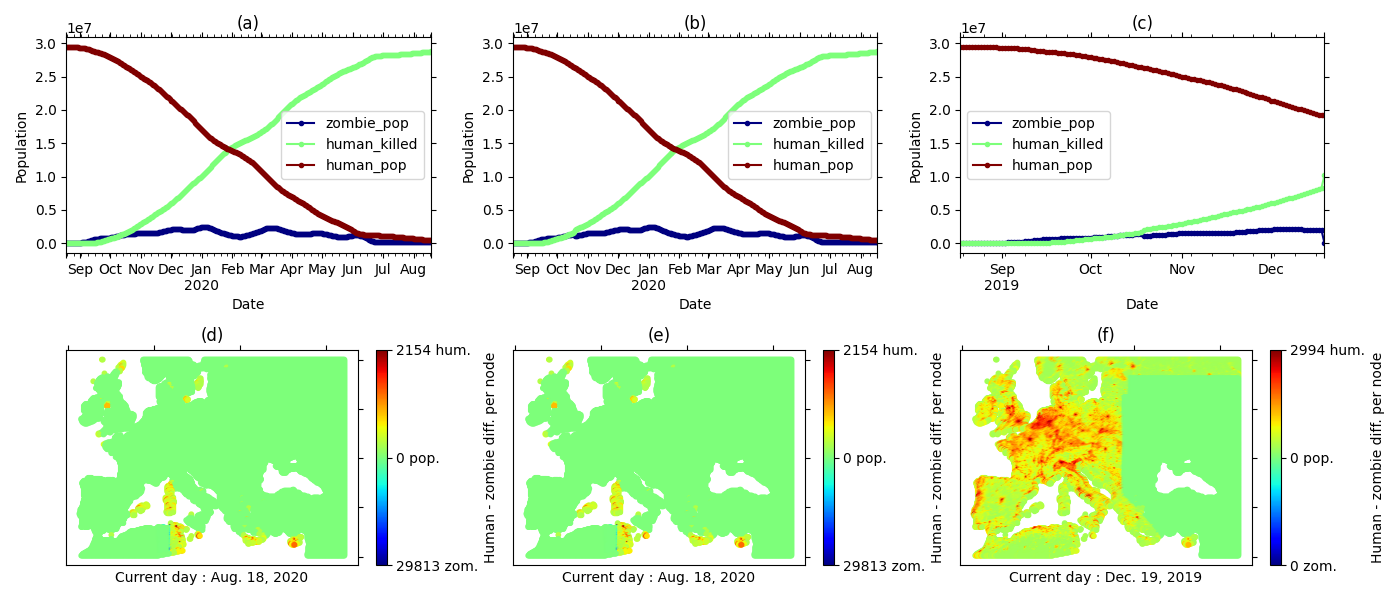

In [5]:
fig, axs = plt.subplots(2,3, figsize = (14,6))
dynamic_wa.plot_evolution(ax = axs[0,0]); axs[0,0].set_title('(a)')
dynamic_military.plot_evolution(ax = axs[0,1]); axs[0,1].set_title('(b)')
dynamic.plot_evolution(ax = axs[0,2]); axs[0,2].set_title('(c)')

dynamic_wa.plot_graph(ax = axs[1,0]); axs[1,0].set_title('(d)')
dynamic_military.plot_graph(ax = axs[1,1]); axs[1,1].set_title('(e)')
dynamic.plot_graph(ax = axs[1,2]); axs[1,2].set_title('(f)')

fig.tight_layout()
fig.savefig('images/comparison.png', dpi = 300,)

<IPython.core.display.Javascript object>


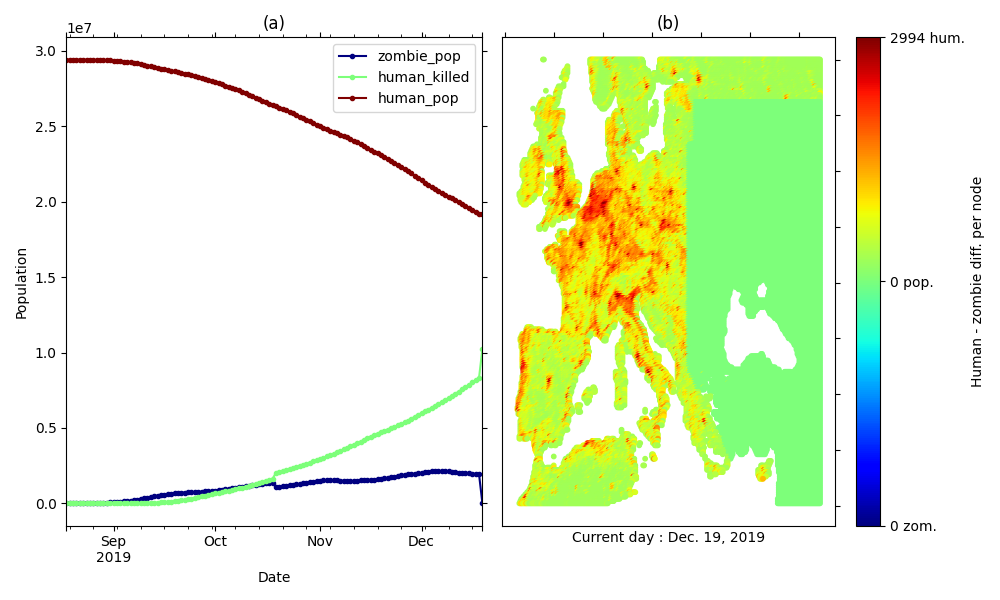

In [6]:
fig, axs = plt.subplots(1,2, figsize = (10,6))
dynamic.plot_all(axs = axs)
axs[0].set_title('(a)'); axs[1].set_title('(b)')
fig.tight_layout()
fig.savefig('images/result_bombs.png', dpi = 300,)

## Conclusions
In the present paper, a model based on graph theory was developed to describe geospatially the European continent, allowing to load attributes to each node, as well as to describe the elevation relationship of the terrain across the edges. The interactions between the three types of populations (humans, zombies and dead people) were denoted in the form of an algorithm, allowing to predict with its execution key aspects such as the arrival of the virus to the city of Brest, as well as the location of the zombies for the planning of the military deployment and execution of military bombs. Using 20 military troops and 3683 bombs, the pandemic was eradicated on December 19th, 2019.

The team of data scientists, located in the city of Brest, will be safe until 9 months after the start of the pandemic, the zombies would arrive the 9 May of 2020, this estimation was made thanks to the propagation model designed using graph theory.


It was observed that although the military forces eliminated a large number of zombies and slowed down the spread of the virus two months after the start of the virus, as time passed the zombies recovered and advanced rapidly, meaning that only 20 troops using this method did not have a significant impact on the dynamics of the virus.


Thanks to the propagation model, it is possible to estimate the way in which the zombies move across the continent, this information could be useful in a scenario in which it would be possible to relocate people to safer places. On the other hand, we show that people located on some islands could be saved due to the difficulty of the zombies to swim. These could be relocation zones for the most vulnerable population, such as children, elderly people, pregnant women, etc.


The methodology used to save the world and kill all the zombies consists of bombing the nodes at the border where the first line of the spread of the virus is located and where the largest number of zombies are clustered. The results of the different experiments performed showed us that there are several results in which we can reduce the number of bombs, saving money and deployment infrastructure, but a greater number of people would die. That is why we decided to use a great number of bombs in order to prioritize the number of people's life.

Finally, we demonstrated that with the use of 3683 bombs it was possible to eradicate the spread of the virus, saving more than 60% of the population compared to the 29 millions of inhabitants at the beginning of the simulation. Unfortunately more than 30% of the humans died in the epidemic, as well as 828675 Km$^2$ of land were affected, which cannot be inhabited for more than 50 years. However, this solution is considered the most viable in terms of saving as many humans as possible four months after the spread of the disease. 
